# LSTM Time series (Keras/Tensorflow)

In [1]:
# %load_ext autoreload
# %autoreload 2
import os

import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from LSTM import *
# tf.compat.v1.disable_v2_behavior()

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

figures saved to ../Figures/Modeling/LSTM


## Data exploration

In [26]:
files = os.listdir('../Datasets/fastStorage/2013-8')
files.sort()  # Short the files (compatible with mac)
files[519]

figures saved to ../Figures/Modeling/LSTM


'340.csv'

In [2]:
# Load data
VM = load_VM('917.csv')
# VM = load_VM('541.csv')
# Make it univariate
df = VM[['CPU usage [MHZ]']]
# df = VM

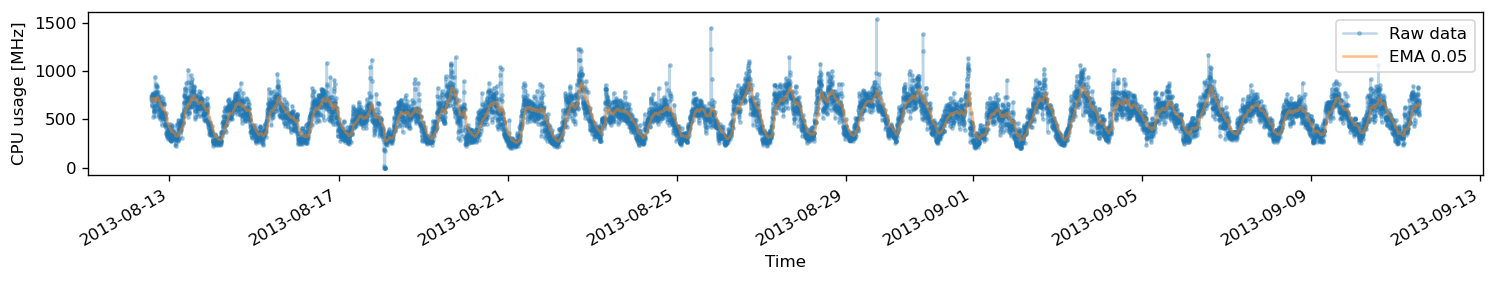

In [3]:
%matplotlib inline
plot_timeSeries(df['CPU usage [MHZ]'], ylabel='CPU usage [MHz]')

Metal device set to: Apple M1


2022-04-12 12:15:41.480630: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-12 12:15:41.480915: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


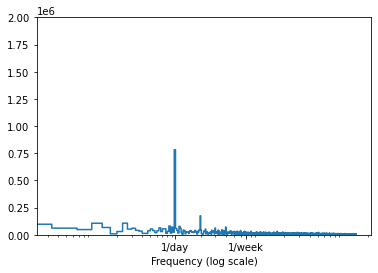

In [5]:
%matplotlib inline
fft = tf.signal.rfft(df['CPU usage [MHZ]'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(VM)
timestamps_per_day = 60*24/5
days_per_dataset = n_samples_h/ (timestamps_per_day)

f_per_day = f_per_dataset/days_per_dataset
plt.step(f_per_day, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 2000000)
# plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 7], labels=['1/day', '1/week'])
_ = plt.xlabel('Frequency (log scale)')

## Split the data

In [3]:
# (70%, 20%, 10%) split for the training, validation, and test sets
train_df, val_df, test_df = split_data(df)

## Normalizing the data

In [4]:
scaler = MinMaxScaler()
train_df, val_df, test_df = data_transformation(scaler, train_df, val_df, test_df)

## Cross modeling

In [4]:
VM_NUM_test = 340
# (80%, 20%, 0%) split for the training, validation from one VM
train_df, val_df, _ = split_data(df, 0.8, 0.19)
# Test set from other VM
VM_test = load_VM(f'{VM_NUM_test}.csv')
df_test = VM_test[['CPU usage [MHZ]']]

# Normalizing
# Train & Validation
scaler = MinMaxScaler()
train_df, val_df, _ = data_transformation(scaler, train_df, val_df, _)
# Test
scaler = MinMaxScaler()
df_test.loc[:, df_test.columns] = scaler.fit_transform(df_test.loc[:, df_test.columns])
test_df = df_test.copy()

/var/folders/mb/34bz2n2j38ldt4zjxtdpnfg80000gp/T/ipykernel_12043/2212480685.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, df_test.columns] = scaler.fit_transform(df_test.loc[:, df_test.columns])


## Adding daily info

In [8]:
df = add_daily_info(df)
# (70%, 20%, 10%) split for the training, validation, and test sets
train_df, val_df, test_df = split_data(df)

/Users/javier.galindos/Library/CloudStorage/OneDrive-FundaciónIMDEASoftware/Documents/Code/intern-project-javier/Modeling/LSTM.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
/Users/javier.galindos/Library/CloudStorage/OneDrive-FundaciónIMDEASoftware/Documents/Code/intern-project-javier/Modeling/LSTM.py:214: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
/Users/javier.galindos/Library/CloudSt

Text(0.5, 1.0, 'Time of day signal')

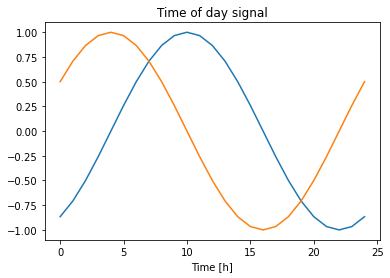

In [9]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

## LSTM

In [5]:
lstm_model = LstmModel(input_width=50,
                      label_width=1,
                      df=df,
                      name='917/labels_1',
                      train_df=train_df,
                      val_df=val_df,
                      test_df=test_df,
                      epoch=100,
                      units=20,
                      layers=1,
                      dropout=0,
                      )

Metal device set to: Apple M1


2022-06-02 11:49:34.070345: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-02 11:49:34.070443: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
# Magic func to use TensorBoard directly in IPython
%load_ext tensorboard

In [12]:
log_dir = f'logs/fit/{lstm_model.name}'
%tensorboard --logdir=logdir

Launching TensorBoard...

In [6]:
IPython.display.clear_output()
history = lstm_model.compile_and_fit(patience=50)

Input shape (batch, time, features): (5981, 50, 1)
Labels shape (batch, time, features): (5981, 1, 1)
Output shape:(5981, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
Beginning training
Epoch 1/100


2022-06-02 11:49:45.993393: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-02 11:49:46.382158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 11:49:46.500773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/47 [..............................] - ETA: 39s - loss: 0.1855 - mean_absolute_error: 0.4141

2022-06-02 11:49:46.668749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 0.0403 - mean_absolute_error: 0.1501

2022-06-02 11:49:47.915255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 11:49:47.960278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 2s 30ms/step - loss: 0.0403 - mean_absolute_error: 0.1501 - val_loss: 0.0046 - val_mean_absolute_error: 0.0519
Epoch 2/100
47/47 [==============================] - 1s 22ms/step - loss: 0.0050 - mean_absolute_error: 0.0553 - val_loss: 0.0037 - val_mean_absolute_error: 0.0475
Epoch 3/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0042 - mean_absolute_error: 0.0501 - val_loss: 0.0032 - val_mean_absolute_error: 0.0441
Epoch 4/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0038 - mean_absolute_error: 0.0466 - val_loss: 0.0030 - val_mean_absolute_error: 0.0422
Epoch 5/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0036 - mean_absolute_error: 0.0445 - val_loss: 0.0029 - val_mean_absolute_error: 0.0416
Epoch 6/100
47/47 [==============================] - 1s 20ms/step - loss: 0.0034 - mean_absolute_error: 0.0434 - val_loss: 0.0028 - val_mean_absolute_error: 0.0402
Epoch 7/100
47/47 [=========

In [7]:
IPython.display.clear_output()
pred = lstm_model.prediction(scaler)

Inference:


2022-06-02 11:42:49.465456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-02 11:42:49.506849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Inference time: 0.30 sec
4/4 [==============================] - 0s 27ms/step - loss: 0.0037 - mean_absolute_error: 0.0459


                                 0
MAE                     105.946266
MAPE                     33.782940
RMSE                    126.463654
MASE                      1.321687
train_time [s]           14.103026
inference_time [s]        0.322522
model_size [B]        22544.000000
IoU                       0.074504
DTW                  673848.451353
forecasting horizon      16.000000
               MAE          MAPE
count  8608.000000   8608.000000
mean    105.946273     33.782941
std      69.057924    171.407912
min       0.067420      0.010400
25%      55.168502     11.223397
50%     100.720017     23.824974
75%     147.710850     43.014277
max    1543.629617  12283.537105


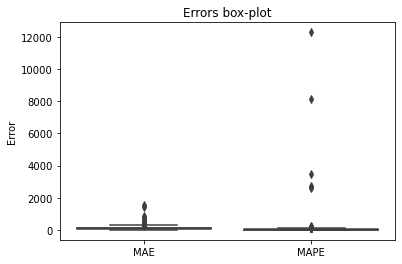

In [8]:
metrics = lstm_model.evaluation(pred,scaler)

In [27]:
val_mape = lstm_model.model.evaluate(lstm_model.window.val[0], lstm_model.window.val[1])

53/53 [==============================] - 1s 10ms/step - loss: 0.0021 - mean_absolute_error: 0.0347


In [12]:
# Figure
%matplotlib tk
test_trf = scaler.inverse_transform(test_df)
test_df_trf = pd.DataFrame(data=test_trf, columns=test_df.columns, index=test_df.index)
fig = plt.figure(dpi=150)
plt.grid()
test_df_trf['CPU usage [MHZ]'].plot(label='actual', color='k')
pred['CPU usage [MHZ]'].plot(label='forecast')
plt.ylabel('CPU usage [MHz]')
plt.title(f'Val MAPE:')
plt.grid()
plt.legend()
plt.show()

In [25]:
%matplotlib tk
defaultKwargs = {'marker': 'o',
                 'linestyle': '',
                 'alpha': 0.3,
                 'markersize': 2}
kwargs_forecast = {'marker': 'o',
                 'linestyle': '',
                 'alpha': 0.5,
                 'markersize': 2,
                  'color': 'tab:orange'}
fig = plt.figure(dpi=200)
plt.grid()
lstm_model.df['CPU usage [MHZ]'].plot(label='actual', color='k', **defaultKwargs)
pred['CPU usage [MHZ]'].plot(label='forecast', **kwargs_forecast)
plt.ylabel('CPU usage [MHz]')
plt.title(f'Val MAE:')
plt.grid()
plt.legend()
plt.show()

In [17]:
test_trf = scaler.inverse_transform(lstm_model.test_df)
test_df_trf = pd.DataFrame(data=test_trf, columns=lstm_model.test_df.columns, index=lstm_model.test_df.index)


In [26]:
fig = plt.figure(dpi=200)
plt.grid()
test_df_trf['CPU usage [MHZ]'].plot(label='actual', color='k', **defaultKwargs)
pred['CPU usage [MHZ]'].plot(label='forecast', **kwargs_forecast)
plt.ylabel('CPU usage [MHz]')
plt.title(f'Val MAE:')
plt.grid()
plt.legend()
plt.show()

## Closed loop predictions

In [48]:
fh = 9
pred = []

In [58]:
fh = 9
pred = []
for i in range(0,len(lstm_model.test_df), fh):
    input_data = lstm_model.test_pred[0][i].reshape((1,-1,1))
    for _ in range(fh):
        pred_next = lstm_model.model.predict(input_data, batch_size=lstm_model.batch_size)
        input_data = np.concatenate((np.reshape(input_data[:,1:,:],(-1,1)), pred_next))
        input_data = np.reshape(input_data, (1,-1,1))
        pred.append(pred_next)

In [60]:
pred = np.array(pred[:len(lstm_model.test_df)]).reshape((-1,1))

In [65]:
# Convert to dataframe
pred_df = pd.DataFrame(pred, columns=['CPU usage [MHZ]'])
pred_df.index = lstm_model.test_df.index
# Inverse transform
pred_trf = scaler.inverse_transform(pred_df)
pred_df_trf = pd.DataFrame(data=pred_trf, columns=['CPU usage [MHZ]'], index=lstm_model.test_df.index)

In [66]:
metrics = lstm_model.evaluation(pred_df_trf, scaler)

In [67]:
# Whole set
# Convert to dataframe
df_trf = scaler.inverse_transform(lstm_model.df)
df_df_trf = pd.DataFrame(data=df_trf, columns=lstm_model.df.columns, index=lstm_model.df.index)
# Test set
test_trf = scaler.inverse_transform(lstm_model.test_df)
test_df_trf = pd.DataFrame(data=test_trf, columns=lstm_model.test_df.columns, index=lstm_model.test_df.index)
val_mae = lstm_model.model.evaluate(lstm_model.val[0], lstm_model.val[1])

# Figure forecast
# Define default kwargs
defaultKwargs = {'marker': 'o',
                 'linestyle': '',
                 'alpha': 0.3,
                 'markersize': 2}
kwargs_forecast = {'marker': 'o',
                   'linestyle': '',
                   'alpha': 0.5,
                   'markersize': 2,
                   'color': 'tab:orange'}
fig = plt.figure(dpi=200)
plt.grid()
lstm_model.df['CPU usage [MHZ]'].plot(label='actual', color='k', **defaultKwargs)
pred_df_trf['CPU usage [MHZ]'].plot(label='forecast', **kwargs_forecast)
plt.ylabel('CPU usage [MHz]')
plt.title(f'Val MAE: {val_mae[1]:.3f}')
plt.grid()
plt.legend()
plt.show()

# Figure zoom
fig = plt.figure(dpi=200)
plt.grid()
test_df_trf['CPU usage [MHZ]'].plot(label='actual', color='k', **defaultKwargs)
pred_df_trf['CPU usage [MHZ]'].plot(label='forecast', **kwargs_forecast)
plt.ylabel('CPU usage [MHz]')
plt.title(f'Val MAE:{val_mae[1]:.3f}')
plt.grid()
plt.legend()
plt.show()

53/53 [==============================] - 1s 9ms/step - loss: 0.1558 - mean_absolute_error: 0.3016


## XAI: Shap

In [7]:
import shap

In [8]:
# Use the training data for deep explainer => can use fewer instances
explainer = shap.DeepExplainer(lstm_model.model, lstm_model.train[0])
# explain the the testing instances (can use fewer instanaces)
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(lstm_model.test[0])
# init the JS visualization code
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


AttributeError: in user code:

    File "/Users/javier.galindos/miniforge3/envs/native_m1/lib/python3.9/site-packages/shap/explainers/_deep/deep_tf.py", line 243, in grad_graph  *
        out = self.model(shap_rAnD)
    File "/Users/javier.galindos/miniforge3/envs/native_m1/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/Users/javier.galindos/miniforge3/envs/native_m1/lib/python3.9/site-packages/shap/explainers/_deep/deep_tf.py", line 26, in custom_record_gradient
        out = tf_backprop._record_gradient("shap_"+op_name, inputs, attrs, results)

    AttributeError: Exception encountered when calling layer "lstm" (type LSTM).
    
    module 'tensorflow.python.eager.backprop' has no attribute '_record_gradient'
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(11962, 50, 1), dtype=float32)
      • mask=None
      • training=False
      • initial_state=None


## Lime

In [7]:
from lime import lime_tabular

In [10]:
explainer = lime_tabular.RecurrentTabularExplainer(lstm_model.train[0],
                                                   mode='regression',
                                                   # training_labels=lstm_model.train[1],
                                                   feature_names=["CPU usage"],
                                                   )

In [30]:
exp = explainer.explain_instance(lstm_model.test[0][111], lstm_model.model.predict, num_features=10)
# exp.show_in_notebook()

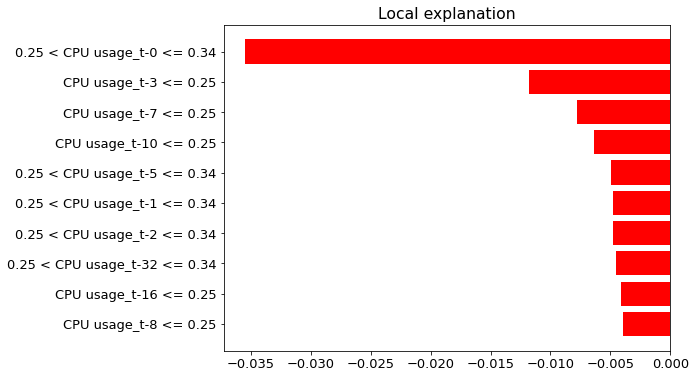

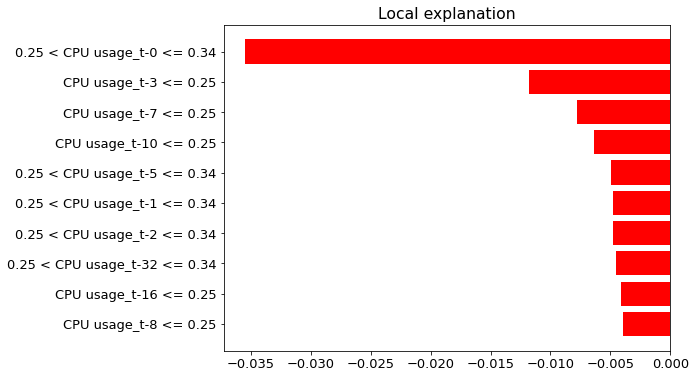

In [31]:
exp.as_pyplot_figure()

In [32]:
exp.show_in_notebook()